## torchkeras的学习
> Pytorch ❤️ Keras 😋😋

torchkeras 是一个通用的pytorch模型训练模版工具，按照如下目标进行设计和实现：
- 好看 (代码优雅，日志美丽，自带可视化)
- 好用 (使用方便，支持 进度条、评估指标、early-stopping等常用功能，支持tensorboard，wandb回调函数等扩展功能)
- 好改 (修改简单，核心代码模块化，仅约200行，并提供丰富的修改使用案例)

### MNIST实战

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchkeras

1. 准备数据

In [ ]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_train = torch.utils.data.Subset(ds_train,range(0,len(ds_train),20))
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
ds_val = torch.utils.data.Subset(ds_val,range(0,len(ds_val),20))
dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)

In [5]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


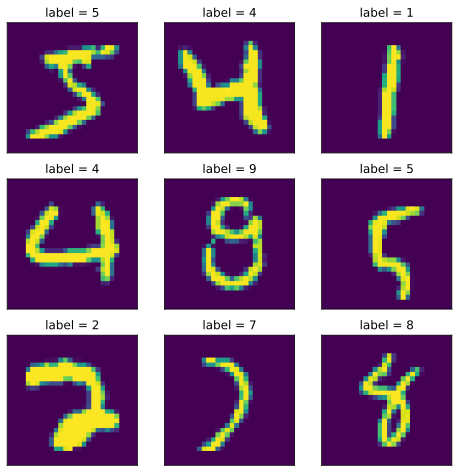

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

2. 创建模型

In [7]:
def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0]
        self.correct += m
        self.total += n

        return m/n

    def compute(self):
        return self.correct.float() / self.total

    def reset(self):
        self.correct -= self.correct
        self.total -= self.total

In [8]:
net = create_net()


model = torchkeras.KerasModel(net,
      loss_fn = nn.CrossEntropyLoss(),
      optimizer= torch.optim.Adam(net.parameters(),lr=5e-3),
      metrics_dict = {"acc":Accuracy()}
    )

from torchkeras import summary
summary(model,input_data=features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 26, 26]                  320
MaxPool2d-2                         [-1, 32, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]               51,264
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                   [-1, 10]                  330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
-----------------------------------------

In [10]:
torchkeras.flop_summary(net,features)

| module           | #parameters or shape   | #flops   |
|:-----------------|:-----------------------|:---------|
| model            | 53.994K                | 0.556G   |
|  conv1           |  0.32K                 |  24.92M  |
|   conv1.weight   |   (32, 1, 3, 3)        |          |
|   conv1.bias     |   (32,)                |          |
|  conv2           |  51.264K               |  0.531G  |
|   conv2.weight   |   (64, 32, 5, 5)       |          |
|   conv2.bias     |   (64,)                |          |
|  linear1         |  2.08K                 |  0.262M  |
|   linear1.weight |   (32, 64)             |          |
|   linear1.bias   |   (32,)                |          |
|  linear2         |  0.33K                 |  40.96K  |
|   linear2.weight |   (10, 32)             |          |
|   linear2.bias   |   (10,)                |          |


3. 训练模型

<<<<<< ⚡️ cuda is used >>>>>>


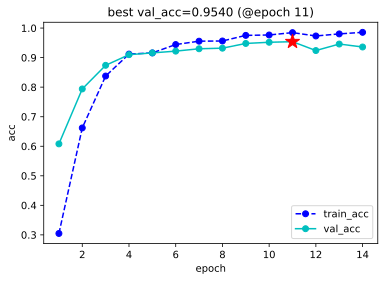

<<<<<< val_acc without improvement in 3 epoch,early stopping >>>>>> 



In [13]:
ckpt_path='checkpoint'
#model.load_ckpt(ckpt_path) #load trained ckpt and continue training
dfhistory=model.fit(train_data=dl_train,
                    val_data=dl_val,
                    epochs=30,
                    patience=3,
                    monitor="val_acc",
                    mode="max",
                    ckpt_path=ckpt_path,
                    plot=True,
                    wandb=False
                   )

In [14]:
model.evaluate(dl_val,quiet=False)

100%|██████████████████████████████████| 4/4 [00:00<00:00, 22.31it/s, val_acc=0.954, val_loss=0.194]


{'val_loss': 0.19388170540332794, 'val_acc': 0.9539999961853027}

4. 验证模型

In [15]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

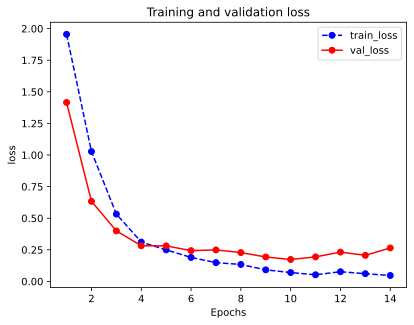

In [16]:
plot_metric(dfhistory,'loss')

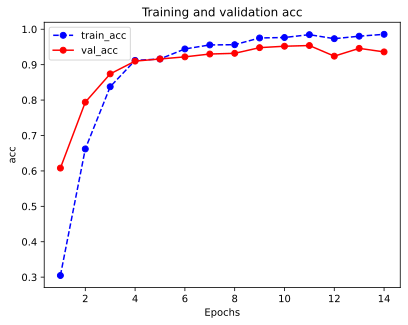

In [17]:
plot_metric(dfhistory,"acc")

In [18]:
model.evaluate(dl_val,quiet=False)

100%|██████████████████████████████████| 4/4 [00:00<00:00, 10.16it/s, val_acc=0.954, val_loss=0.194]


{'val_loss': 0.19388170540332794, 'val_acc': 0.9539999961853027}

5. 使用模型

y_pred =  4
y_prob =  0.9993295669555664


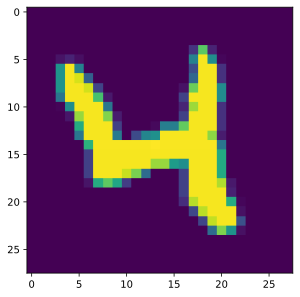

In [22]:
net = model.net
net.eval();

device = ('cuda' if torch.cuda.is_available() else 'cpu')
img,label = ds_train[1]
tensor = img.to(device)

y_pred = torch.argmax(net(tensor[None,...]))
y_prob = torch.softmax(net(tensor[None,...]),dim=-1).max()

img = img.permute(1,2,0)
plt.imshow(img)
print('y_pred = ', y_pred.item())
print('y_prob = ', y_prob.item())

In [23]:
#  used the saved model parameters
net_clone = create_net()

model_clone = torchkeras.KerasModel(net_clone,loss_fn = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(net_clone.parameters(),lr = 0.001),
             metrics_dict={"acc":Accuracy()})

model_clone.load_ckpt("checkpoint")

### wandb可视化案例

In [26]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchkeras

0. 设置超参数

In [27]:
from argparse import Namespace
config = Namespace(
    batch_size = 256,
    lr = 1e-3,
    dropout_p = 0.1,
    )

1. 准备数据

In [28]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, num_workers=2)

In [29]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


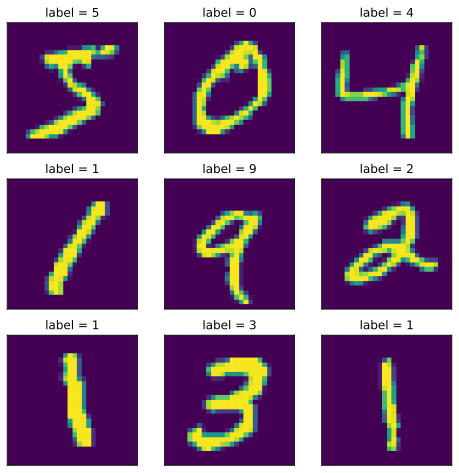

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#visual some samples
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

2. 创建模型

In [31]:
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

net = create_net(config)

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0]
        self.correct += m
        self.total += n

        return m/n

    def compute(self):
        return self.correct.float() / self.total

    def reset(self):
        self.correct -= self.correct
        self.total -= self.total

In [32]:
model = torchkeras.KerasModel(net,
      loss_fn = nn.CrossEntropyLoss(),
      optimizer= torch.optim.Adam(net.parameters(),lr=0.001),
      metrics_dict = {"acc":Accuracy()},
    )

from torchkeras import summary
summary(model,input_data=features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 26, 26]                  320
MaxPool2d-2                         [-1, 32, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]               51,264
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                   [-1, 10]                  330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
-----------------------------------------

<<<<<< ⚡️ cuda is used >>>>>>


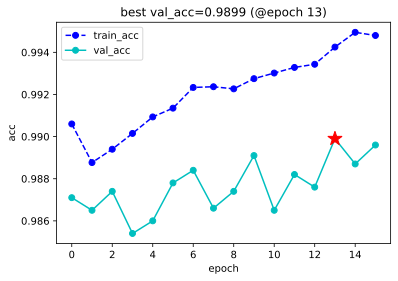

wandb: Currently logged in as: moguw. Use `wandb login --relogin` to force relogin


best_val_acc,▁▁▂▂▂▃▄▄▄▆▆▆▆███
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
lr,▁███████████████
train_acc,▃▁▂▃▃▄▅▅▅▆▆▆▆▇██
train_loss,▆█▇▆▅▅▄▄▄▃▃▃▃▂▁▁
val_acc,▄▃▄▁▂▅▆▃▄▇▃▅▄█▆█
val_loss,▆▆▄█▆▅▃█▅▃▇█▆▁▄▄
best_score,0.9899
best_val_acc,0.9899
epoch,15.0
lr,0.001


In [34]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(project='mnist_torchkeras',
                         config=config,
                         name=None,
                         save_code=True,
                         save_ckpt=True)

dfhistory=model.fit(train_data=dl_train,
                    val_data=dl_val,
                    epochs=15,
                    patience=5,
                    monitor="val_acc",
                    mode="max",
                    ckpt_path='checkpoint.pt',
                    callbacks = [wandb_cb]
                   )

5. 案例分析

In [35]:
#resume the run
import wandb
run = wandb.init(project='mnist_torchkeras', id=model.run_id, resume='must')

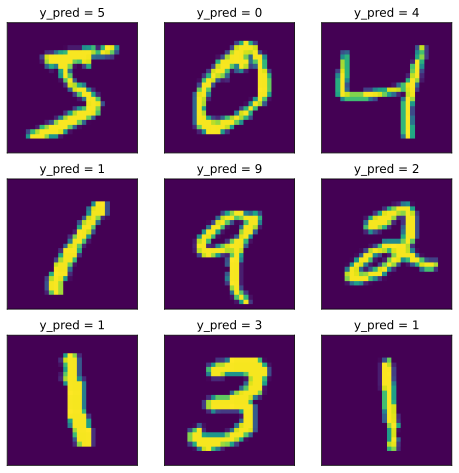

In [36]:
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8))
for i in range(9):
    img,label = ds_train[i]
    tensor = img.to(device)
    y_pred = torch.argmax(net(tensor[None,...]))
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [38]:
def data2fig(data):
    fig = plt.Figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([])
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

In [37]:
from tqdm import tqdm
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])

In [39]:
for i in tqdm(range(1000)):
    features,label = ds_val[i]
    tensor = features.to(device)
    y_pred = torch.argmax(net(tensor[None,...]))

    # log badcase
    if y_pred!=label:
        if len(bad_cases.data)<20:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            bad_cases.add_data(input_img,label,y_pred)

    # log goodcase
    else:
        if len(good_cases.data)<20:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            good_cases.add_data(input_img,label,y_pred)

100%|██████████| 1000/1000 [00:07<00:00, 140.07it/s]


In [40]:
wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})


6. 保存数据集/模型/代码

In [41]:
# save our dataset
arti_dataset = wandb.Artifact('mnist', type='dataset')
arti_dataset.add_dir('mnist/')
wandb.log_artifact(arti_dataset)

wandb: Adding directory to artifact (./mnist)... Done. 0.3s


<Artifact mnist>

In [ ]:
# save the code
# colab就不用了
arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file("/content/torchkeras的学习.ipynb")
wandb.log_artifact(arti_code)

In [48]:
# save the model

arti_model = wandb.Artifact('checkpoint', type='model')
arti_model.add_file(model.ckpt_path)
wandb.log_artifact(arti_model)

<Artifact checkpoint>

In [49]:
wandb.finish()

best_score,0.9899
best_val_acc,0.9899
epoch,15
lr,0.001
train_acc,0.9948
train_loss,0.01565
val_acc,0.9896
val_loss,0.03813


7. 复现

In [52]:
import pandas as pd
import wandb
api = wandb.Api()

entity, project = "moguw", "mnist_torchkeras"  # set to your entity and project

def get_best_run_id(entity,project,metric_mode=model.mode):
    runs = api.runs(entity + "/" + project)
    data = []
    for run in runs:
        run_info = {'run_id':run.id,'run_name':run.name,'best_score':run.summary['best_score']}
        run_config = {k: v for k,v in run.config.items() if not k.startswith('_')}
        run_info.update(run_config)
        data.append(run_info)
    dfruns = pd.DataFrame(data)
    dfruns.sort_values(by = 'best_score',
                   ascending= False if metric_mode=='max' else True,
                   inplace = True)
    best_run_id = dfruns['run_id'].iloc[0]
    return best_run_id

def get_model_versions(entity,project):
    model_versions = api.artifact_versions('model',
        name = entity + "/" + project+'/' + 'checkpoint')
    return [x.version for x in model_versions]

In [ ]:
best_run_id = get_best_run_id(entity,project)
print(best_run_id)

In [ ]:
model_versions = get_model_versions(entity,project)
print(model_versions)

In [55]:
best_run = api.run(path= entity + "/" + project+'/'+ best_run_id)

In [ ]:
best_model_arti = None
for arti in best_run.logged_artifacts():
    if arti.type=='model':
        best_model_arti = arti

print(best_model_arti.version)

best_model_arti.download(root='best_ckpt')